# N-Grams Frequency - MultiOutputClassifier(XGBClassifier())

## Set Up

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import re
import json
import pickle
import pandas as pd
from pathlib import Path

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import sys
# Add the workspace root to sys.path so 'scripts' can be imported
sys.path.append(str(Path.cwd().parents[3]))

from scripts.feature_extractions.n_grams import get_n_grams_from_files


In [3]:
PATH = Path.cwd().parents[3]
MODEL_PATH = os.path.join(PATH, 'models/baseline')
DATA_PATH = os.path.join(PATH, 'data')
EX_PATH = os.path.join(DATA_PATH, 'external/crpwarner/large')
HEX_PATH = os.path.join(EX_PATH, 'hex')
name = 'opcode_n_grams'

### Load Model

In [4]:
model_paths = list(Path(MODEL_PATH).glob(f'{name}-f1-*.pkl'))

In [5]:
def get_best_model_path(paths):
    best_f1_score = -1.0
    best_path = None

    for path in paths:
        # Extract the F1 score using a regular expression
        match = re.search(r'f1-(\d+\.\d+)\.(pkl|json|keras)$', path.name)
        if match:
            try:
                f1_score = float(match.group(1))
                if f1_score > best_f1_score:
                    best_f1_score = f1_score
                    best_path = path
            except ValueError:
                # Handle cases where the extracted string might not be a valid float
                print(f"Warning: Could not parse F1 score from filename: {path.name}")
        else:
            print(f"Warning: F1 score pattern not found in filename: {path.name}")

    return best_path

In [6]:
best_model_path = get_best_model_path(model_paths)

if best_model_path:
    model = pickle.load(open(best_model_path, 'rb'))

In [7]:
with open(os.path.join(DATA_PATH, f'processed/{name}/features.json'), 'r', encoding='utf-8') as f:
    train_cols = json.load(f)

In [8]:
train_cols

['add add',
 'add add mstore',
 'add add swap',
 'add and',
 'add and dup',
 'add calldataload',
 'add calldataload push',
 'add calldataload swap',
 'add dup',
 'add dup add',
 'add dup dup',
 'add dup mstore',
 'add dup push',
 'add dup swap',
 'add gt',
 'add jumpdest',
 'add jumpdest push',
 'add mload',
 'add mload dup',
 'add mload push',
 'add mload swap',
 'add mstore',
 'add mstore dup',
 'add mstore jumpdest',
 'add mstore pop',
 'add mstore push',
 'add mstore swap',
 'add push',
 'add push add',
 'add push dup',
 'add push jump',
 'add push mload',
 'add push mstore',
 'add push not',
 'add push push',
 'add push sha',
 'add push swap',
 'add sload',
 'add sload push',
 'add sload swap',
 'add swap',
 'add swap dup',
 'add swap jump',
 'add swap jumpdest',
 'add swap log',
 'add swap pop',
 'add swap push',
 'add swap return',
 'add swap revert',
 'add swap swap',
 'address dup',
 'address dup push',
 'address gasprice',
 'address gasprice sha',
 'address push',
 'and calle

## Mint

### Load and Prepare Data

In [9]:
df = pd.read_excel(os.path.join(EX_PATH, 'sample/mint.xlsx'))
df['Address'] = df['Address'].str.lower()
df = df.set_index('Address')
df.head()

,TP?
Address,
0x0fef20d2c4ee011fa0389e69e9fa92a2291b63c8,Yes
0xd7cc0deb9dd11be95068bf2d7a3d082b8ba9bf04,Yes
0xa1b756be589441519b1a08e16bc4f60ab177d916,Yes
0x514bc174df04a4b04ae2be81ee8c788c3796b06b,Yes
0x1354c8c1a66c2573ce9cc3e92e98d17869501a46,Yes


In [10]:
df.isna().sum()

TP?    0
dtype: int64

In [11]:
files = []
y = []

for path in list(Path(HEX_PATH).glob('*.hex')):
    address = path.stem.lower()
    if address in df.index:
        files.append(path)
        tp_value = df.loc[address, 'TP?']
        if isinstance(tp_value, pd.Series):
            tp_value = tp_value.iloc[0]
        y.append(1 if tp_value == 'Yes' else 0)

X = get_n_grams_from_files(files)

  0%|          | 0/92 [00:00<?, ?it/s]invalid instruction: PUSH18
invalid instruction: PUSH32
  4%|▍         | 4/92 [00:00<00:02, 33.25it/s]invalid instruction: PUSH31
invalid instruction: PUSH27
invalid instruction: PUSH27
  9%|▊         | 8/92 [00:00<00:03, 26.86it/s]invalid instruction: PUSH25
invalid instruction: PUSH32
 14%|█▍        | 13/92 [00:00<00:02, 33.55it/s]invalid instruction: PUSH32
invalid instruction: PUSH15
invalid instruction: PUSH22
 20%|█▉        | 18/92 [00:00<00:01, 37.64it/s]invalid instruction: PUSH31
invalid instruction: PUSH31
 24%|██▍       | 22/92 [00:00<00:02, 30.92it/s]invalid instruction: PUSH17
invalid instruction: PUSH28
 29%|██▉       | 27/92 [00:00<00:01, 35.77it/s]invalid instruction: PUSH18
invalid instruction: PUSH19
invalid instruction: PUSH24
invalid instruction: PUSH23
 36%|███▌      | 33/92 [00:00<00:01, 40.26it/s]invalid instruction: PUSH25
invalid instruction: PUSH9
invalid instruction: PUSH20
 41%|████▏     | 38/92 [00:01<00:01, 34.86it/s]i

In [12]:
X

,add calldataload,add calldataload push,add dup,add dup add,add dup dup,add dup push,add dup sload,add dup swap,add gt,add mload,...,unknown jumpdest pop,unknown jumpdest push,unknown jumpdest swap,unknown log,unknown push,unknown swap,unknown swap unknown,unknown unknown,unknown unknown swap,unknown unknown unknown
address,,,,,,,,,,,,,,,,,,,,,
0x71a982a028c9d4b0566041a78df12b810462e155,0,0,14,0,10,2,0,0,1,3,...,0,0,0,0,1,0,0,3,0,2
0x8d3bd2940bbc5ed724d138934374e4c0ad3c0027,0,0,13,0,12,1,0,0,0,4,...,0,0,0,0,1,0,0,0,0,0
0x4c0c2052dfdb2d0932644f7b2d4bea509678b9d9,0,0,16,0,11,0,0,4,1,2,...,0,1,0,0,0,0,0,2,0,1
0x0d42fb07a685d2ff9d6bb93df0389946192cd322,0,0,2,0,2,0,0,0,0,2,...,0,0,0,0,1,0,0,0,0,0
0x7dd2f15b4a8c8e14da5eaa7b635221d4b39c41cc,0,0,1,0,1,0,0,0,0,1,...,1,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0x7e9d5e7655bf3ee30043ca24a55eb6f799e0ee54,0,0,6,0,6,0,0,0,0,2,...,0,0,0,0,1,0,0,3,0,1
0x03260e1b0f53e1a1f93cf126a7ca42a1c71648d6,0,0,8,2,4,0,0,2,0,1,...,0,0,0,2,1,3,2,9,2,5
0xfdf475788c31c57e85f2c48add16164fb5ac84e3,1,0,11,0,8,2,0,1,1,2,...,0,0,0,0,0,0,0,0,0,0


In [13]:
y[:5]

[1, 1, 1, 1, 1]

In [14]:
X = X.reindex(columns=train_cols, fill_value=0).reset_index(drop=True)

### Evaluate

In [15]:
y_pred = model.predict(X)

In [16]:
y_pred = y_pred[:, 0]

In [17]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.14      0.93      0.25        14
           1       0.00      0.00      0.00        78

    accuracy                           0.14        92
   macro avg       0.07      0.46      0.12        92
weighted avg       0.02      0.14      0.04        92



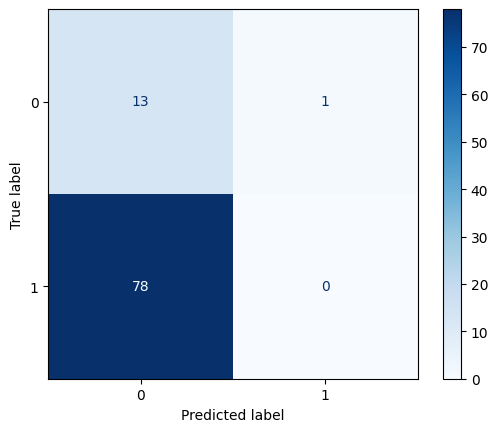

In [18]:
cm = confusion_matrix(y, y_pred)
cm_display = ConfusionMatrixDisplay(cm)
cm_display.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()

## Leak

### Load and Prepare Data

In [19]:
df = pd.read_excel(os.path.join(EX_PATH, 'sample/leak.xlsx'))
df['Address'] = df['Address'].str.lower()
df = df.set_index('Address')
df.head()

,TP?
Address,
0x0290ea3c728981725689187763f6c63a68e192b8,Yes
0x054ad3cd4a66f14bf5c0de2548a53be66995a4f6,Yes
0x0566c17dc2a9efcaa2f63e04cf06a69e8fc77f60,No
0x10c8324b20b7266c445944f043f53f6a77ea0bd4,Yes
0x10cc060f6f9b2e5dcdb23f1361e4b368a7daec73,Yes


In [20]:
df.isna().sum()

TP?    0
dtype: int64

In [21]:
files = []
y = []

for path in list(Path(HEX_PATH).glob('*.hex')):
    address = path.stem.lower()
    if address in df.index:
        files.append(path)
        tp_value = df.loc[address, 'TP?']
        if isinstance(tp_value, pd.Series):
            tp_value = tp_value.iloc[0]
        y.append(1 if tp_value == 'Yes' else 0)

X = get_n_grams_from_files(files)

 10%|█         | 9/87 [00:00<00:02, 35.43it/s]invalid instruction: PUSH30
invalid instruction: PUSH17
invalid instruction: PUSH31
 16%|█▌        | 14/87 [00:00<00:02, 28.21it/s]invalid instruction: PUSH14
invalid instruction: PUSH28
invalid instruction: PUSH30
invalid instruction: PUSH24
invalid instruction: PUSH27
invalid instruction: PUSH30
 25%|██▌       | 22/87 [00:00<00:01, 38.98it/s]invalid instruction: PUSH27
invalid instruction: PUSH23
invalid instruction: PUSH8
 32%|███▏      | 28/87 [00:00<00:01, 35.93it/s]invalid instruction: PUSH17
invalid instruction: PUSH8
invalid instruction: PUSH5
invalid instruction: PUSH10
invalid instruction: PUSH32
 39%|███▉      | 34/87 [00:00<00:01, 40.97it/s]invalid instruction: PUSH23
invalid instruction: PUSH17
invalid instruction: PUSH19
invalid instruction: PUSH32
invalid instruction: PUSH27
 53%|█████▎    | 46/87 [00:01<00:00, 41.05it/s]invalid instruction: PUSH31
invalid instruction: PUSH26
 59%|█████▊    | 51/87 [00:01<00:00, 42.59it/s]inv

In [22]:
X

,add add,add calldataload,add calldataload dup,add dup,add dup add,add dup calldataload,add dup dup,add dup mload,add dup push,add dup sload,...,unknown jumpdest add,unknown jumpdest div,unknown jumpdest dup,unknown jumpdest eq,unknown jumpdest pop,unknown jumpdest push,unknown jumpdest swap,unknown push,unknown unknown,unknown unknown unknown
address,,,,,,,,,,,,,,,,,,,,,
0xf6962cfe3b9618374097d51bc6691efb3974d06f,0,0,0,6,0,0,6,0,0,0,...,0,2,3,0,0,0,0,0,0,0
0x666c549f5a01167f1aa19bb68be552441f520895,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,2,1
0x76bc9e61a1904b82cbf70d1fd9c0f8a120483bbb,0,3,0,18,3,0,4,0,2,0,...,0,0,0,0,0,0,0,0,1,0
0x10cc060f6f9b2e5dcdb23f1361e4b368a7daec73,0,0,0,3,0,0,2,0,0,0,...,0,2,2,0,0,0,4,0,5,2
0xa99f34b4672ff3a9837fd93dea375ccfbb83c89a,0,1,1,11,2,0,1,0,2,2,...,0,0,0,0,1,2,0,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0x8a52499ff8c65cedd4d7ccc283a0dab6df285fe2,0,7,0,39,9,0,13,0,3,0,...,0,0,0,0,1,0,1,1,4,1
0x6b9ee9e79bb893d394da79e2ea51685d1855318e,2,10,0,32,0,0,13,2,5,0,...,0,3,0,0,0,2,0,2,2,1
0xdf482745749ad7057f4ebe246975ff2f2ddeef78,0,1,1,11,0,0,8,0,2,0,...,0,1,0,0,0,0,0,0,0,0


In [23]:
y[:5]

[1, 1, 1, 1, 0]

In [24]:
X = X.reindex(columns=train_cols, fill_value=0).reset_index(drop=True)

### Evaluate

In [25]:
y_pred = model.predict(X)

In [26]:
y_pred = y_pred[:, 1]

In [27]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.15      1.00      0.26        13
           1       0.00      0.00      0.00        74

    accuracy                           0.15        87
   macro avg       0.07      0.50      0.13        87
weighted avg       0.02      0.15      0.04        87



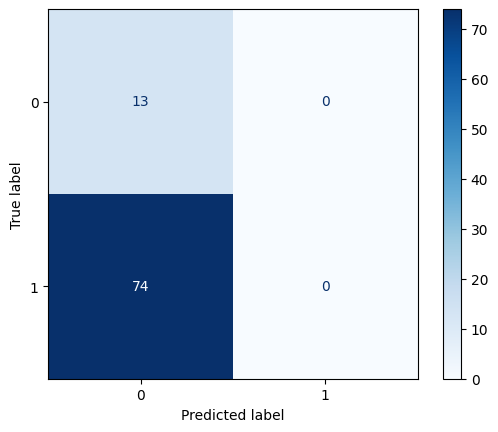

In [28]:
cm = confusion_matrix(y, y_pred)
cm_display = ConfusionMatrixDisplay(cm)
cm_display.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()

## Limit

### Load and Prepare Data

In [29]:
df = pd.read_excel(os.path.join(EX_PATH, 'sample/limit.xlsx'))
df['Address'] = df['Address'].str.lower()
df = df.set_index('Address')
df.head()

,TP?
Address,
0xe5f3c6d2b47cbe2cf936b9521466bac2422ebef8,Yes
0xa623b5a542c0d7daadef321042a04c600b03a8cb,Yes
0xe412189da2dfa188a1a61633114b8732bbbfba19,Yes
0x9fcf7acdc11fd904c4b73a009909c7f00efc4844,Yes
0x921a5dce3dfed5cccfbb2e593f2978533bc66110,Yes


In [30]:
df.isna().sum()

TP?    0
dtype: int64

In [31]:
files = []
y = []

for path in list(Path(HEX_PATH).glob('*.hex')):
    address = path.stem.lower()
    if address in df.index:
        files.append(path)
        tp_value = df.loc[address, 'TP?']
        if isinstance(tp_value, pd.Series):
            tp_value = tp_value.iloc[0]
        y.append(1 if tp_value == 'Yes' else 0)

X = get_n_grams_from_files(files)

  0%|          | 0/91 [00:00<?, ?it/s]invalid instruction: PUSH32
invalid instruction: PUSH20
invalid instruction: PUSH11
  9%|▉         | 8/91 [00:00<00:01, 70.20it/s]invalid instruction: PUSH19
invalid instruction: PUSH5
invalid instruction: PUSH28
invalid instruction: PUSH29
invalid instruction: PUSH25
invalid instruction: PUSH17
 18%|█▊        | 16/91 [00:00<00:01, 49.93it/s]invalid instruction: PUSH26
invalid instruction: PUSH28
invalid instruction: PUSH29
invalid instruction: PUSH21
invalid instruction: PUSH28
 24%|██▍       | 22/91 [00:00<00:01, 51.60it/s]invalid instruction: PUSH13
invalid instruction: PUSH29
 31%|███       | 28/91 [00:00<00:01, 43.10it/s]invalid instruction: PUSH27
invalid instruction: PUSH29
invalid instruction: PUSH18
invalid instruction: PUSH30
invalid instruction: PUSH32
invalid instruction: PUSH22
invalid instruction: PUSH29
 38%|███▊      | 35/91 [00:00<00:01, 48.76it/s]invalid instruction: PUSH26
invalid instruction: PUSH10
invalid instruction: PUSH24
i

In [32]:
X

,add calldataload,add calldataload push,add dup,add dup add,add dup calldataload,add dup dup,add dup iszero,add dup push,add dup sload,add dup swap,...,unknown jumpdest eq,unknown jumpdest pop,unknown jumpdest push,unknown jumpdest swap,unknown log,unknown push,unknown swap,unknown unknown,unknown unknown push,unknown unknown unknown
address,,,,,,,,,,,,,,,,,,,,,
0x1f4a9567c1f98a8c9d7f026827f099b41a2e54d6,0,0,2,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0x76bc9e61a1904b82cbf70d1fd9c0f8a120483bbb,3,3,18,3,0,4,0,2,0,6,...,0,0,0,0,0,0,0,1,0,0
0xa5d77efbc45d574b689d7f1202cf817e23febb97,1,1,13,3,0,5,0,0,0,5,...,0,0,0,0,0,1,1,3,0,1
0xb08fc1db58ef5e15a6f97d8f63b2bb4a14b9df37,0,0,2,0,0,2,0,0,0,0,...,0,0,0,0,0,0,1,6,0,2
0x40165bd6d657b63cb6f8f4a3525ac05bbf74bd93,10,7,13,0,0,5,0,3,0,5,...,0,0,0,0,1,0,1,8,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0x4c567c3363cc42c5a42c6d8bf01503fd1d0b91cd,0,0,2,0,0,2,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
0x3fb1926a7d1cc68d4166d99c3483465885074f2f,0,0,14,0,1,10,1,2,0,0,...,0,0,0,0,0,1,0,0,0,0
0xfb5fb992b64c86fbcb33ba151abd8ecbcc611bde,0,0,16,0,1,12,1,2,0,0,...,0,0,0,0,0,1,0,1,1,0


In [33]:
y[:5]

[1, 1, 1, 0, 1]

In [34]:
X = X.reindex(columns=train_cols, fill_value=0).reset_index(drop=True)

### Evaluate

In [35]:
y_pred = model.predict(X)

In [36]:
y_pred = y_pred[:, 2]

In [37]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.13      0.77      0.22        13
           1       0.77      0.13      0.22        78

    accuracy                           0.22        91
   macro avg       0.45      0.45      0.22        91
weighted avg       0.68      0.22      0.22        91



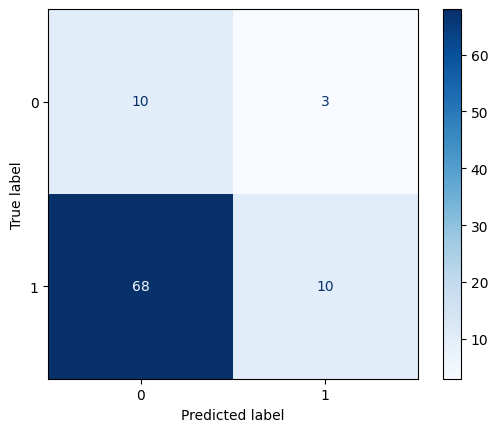

In [38]:
cm = confusion_matrix(y, y_pred)
cm_display = ConfusionMatrixDisplay(cm)
cm_display.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()